<a id='on_qvm'></a>

# Running on the IBMQ cloud simulators, QVM or QPU

We have seen examples of running QAOA on mostly simulators. However, we may also want to run them on the the Pyquil's QVM, IBMQ cloud simulators or even the real QPU. We demonstrate here the usage of such devices on OpenQAOA. The cloud devices would require the user to pass a set of credentials provided by the device hosts, for instance, IBMQ credentials for devices hosted on IBMQ cloud. For running computations on Rigetti's devices the user can assign specific device specific arguments (for e.g. `as_qvm`) during the device creation. The users must also remember that they should run `qvm` and `quilc` processes on their machines to use Rigetti simulators. For more information on this, see [Rigetti's docs](https://pyquil-docs.rigetti.com/en/v2.7.0/start.html#setting-up-server-mode-for-pyquil).

<!-- We now walk through the above example again, only this time running on the QVM. As in [Simulating Sampling Noise](#nshots), we will calculate the cost function twice - once with 5 samples per point, and once with 1000 samples per point. -->
For the purpose of this notebook, we will try to optimize a Number Partition problem. For easy problem creation, we will use the in-built OpenQAOA `NumberPartition` class.

## Begin by importing necessary modules

In [1]:
#some regular python libraries
import networkx as nx
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

#import problem classes from OQ for easy problem creation
from openqaoa.problems.problem import NumberPartition

#import the QAOA workflow model
from openqaoa.workflows.optimizer import QAOA

#import method to specify the device
from openqaoa.devices import create_device

## Step 1: Create a problem instance
We begin by creating a random problem instance using the NumberPartition class. 

We can also visualize the corresponding QUBO and verify that NumberPartition indeed produces a fully-connected QUBO problem with the following the steps:
- Extract the Hamiltonian from the QUBO problem
- Use the utility function to convert the Hamiltonian into its corresponding graph
- Use the graph plotter to visualize the obtained graph. 

NOTE: Converting the Hamiltonian to a graph loses information on the constant factor

In [2]:
# Find partition of a list of 8 numbers generated randomly
np = NumberPartition.random_instance(n_numbers=8)
np_qubo = np.get_qubo_problem()

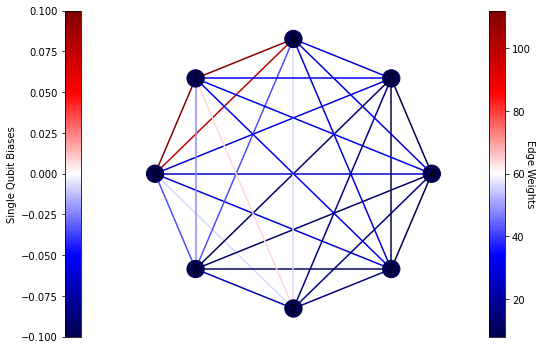

In [3]:
# visualize the QUBO form on a graph
from openqaoa.utilities import plot_graph, graph_from_hamiltonian

#extract Hamiltonain
cost_hamil = np_qubo.hamiltonian

#convert Hamiltonian to graph
cost_gr = graph_from_hamiltonian(cost_hamil)

#plot the graph
plot_graph(cost_gr)

In [4]:
print(np_qubo.asdict())

{'terms': [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [3, 4], [3, 5], [3, 6], [3, 7], [4, 5], [4, 6], [4, 7], [5, 6], [5, 7], [6, 7]], 'weights': [42.0, 56.0, 28.0, 28.0, 28.0, 98.0, 112.0, 24.0, 12.0, 12.0, 12.0, 42.0, 48.0, 16.0, 16.0, 16.0, 56.0, 64.0, 8.0, 8.0, 28.0, 32.0, 8.0, 28.0, 32.0, 28.0, 32.0, 112.0], 'constant': 199, 'n': 8}


#### Extract the exact solution



In [5]:
# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian

energy, configuration = ground_state_hamiltonian(cost_hamil)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: 1.0, Solution: ['11111000', '11110100', '11101100', '10111100', '11000010', '10100010', '10011010', '01111010', '10010110', '01110110', '10001110', '01101110', '00111110', '11000001', '10010001', '01110001', '10001001', '01101001', '10000101', '01100101', '01011101', '00111101', '01000011', '00010011', '00001011', '00000111']


## Step 2: Build the QAOA model on QPUs and cloud simulators
 - Initialize the model (with default parameters)
 - Optionally set the following properties for the model
     - `model.set_device(...)`: Set the device
         - The device properties include the location of the device `[local, qcs, ibmq]` and the device name. Full list of devices available at              `openqaoa.workflows.parameters.qaoa_parameters.ALLOWED_DEVICES`
     - `model.set_circuit_properties(...)`: Sets the circuit properties. Mainly used for:
         - `p`: the number of layers
         - `param_type`: the desired parameterisation to be chosen between `['standard', 'extended', 'fourier', annealing]`
         - `init_type`: the initialisation stratefy for param_type. To be chosen between `['ramp', 'random', 'custom']`
     - `model.set_backend_properties(...)`
     - `model.set_classical_optimizer(...)`


    
For more details on the configurable properties, please refer to the documentation

### Demo for IBMQ cloud simulators and QPUs

In [17]:
qpu_credentials ={
    "api_token": "<ENTER API TOKEN HERE>",
    "hub": "IBMQ HUB",
    "group": "IBMQ GROUP", 
    "project": "IBMQ PROJECT"
}

In [18]:
# initialize model with default configurations
q_qiskit = QAOA()

In [19]:
# device
qiskit_cloud = create_device(location='ibmq', name='simulator_statevector', **qpu_credentials)
q_qiskit.set_device(qiskit_cloud)

# circuit properties
q_qiskit.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties (already set by default)
q_qiskit.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q_qiskit.set_classical_optimizer(method='nelder-mead', maxiter=10, cost_progress=True,
                                 parameter_log=True, optimization_progress=True)

### Demo for Rigetti QPUs and QVMs

In [8]:
rigetti_args ={
    'as_qvm':True, 
    'execution_timeout':10,
    'compiler_timeout':10
}

In [9]:
# initialize model with default configurations
q_pyquil = QAOA()

In [21]:
n_qubits = np_qubo.n
# device
rigetti_device = create_device(location='qcs', name=f'{n_qubits}q-qvm', **rigetti_args)

q_pyquil.set_device(rigetti_device)

# circuit properties
q_pyquil.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties (already set by default)
q_pyquil.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q_pyquil.set_classical_optimizer(method='nelder-mead', maxiter=200, cost_progress=True,
                                 parameter_log=True, optimization_progress=True)

## Step 3: Compile and Optimize

- Once the QAOA model is configured, we need to compile it. **Compilation is necessary** because the QAOA solver has to interact with the problem in to be able to create the underlying QAOA circuit.
- The problem is ready to be optimized now. The user can call `model.optimize()` to initiate the optimization loop. 

In [20]:
q_qiskit.compile(np_qubo)

	  ### Summary ###
OpenQAOA has ben compiled with the following properties
Solving QAOA with  simulator_statevector  on  ibmq
Using p=2 with standard parameters initialsied as rand
OpenQAOA will optimize using nelder-mead, with up to 10 maximum iterations. Each iteration will contain 100 shots
The total numner of shots is set to maxiter*shots = 1000


In [22]:
q_pyquil.compile(np_qubo) 

	  ### Summary ###
OpenQAOA has ben compiled with the following properties
Solving QAOA with  8q-qvm  on  qcs
Using p=2 with standard parameters initialsied as rand
OpenQAOA will optimize using nelder-mead, with up to 200 maximum iterations. Each iteration will contain 100 shots
The total numner of shots is set to maxiter*shots = 20000


In [13]:
q_qiskit.optimize()

optimization completed.


In [23]:
q_pyquil.optimize()

optimization completed.


## Step 4: Accessing the results

The process of obtaining the results for models with either device looks exactly the same. Therefore, to keep this notebook succinct, we only analyze results produced by one device.

In [24]:
opt_results = q_pyquil.results

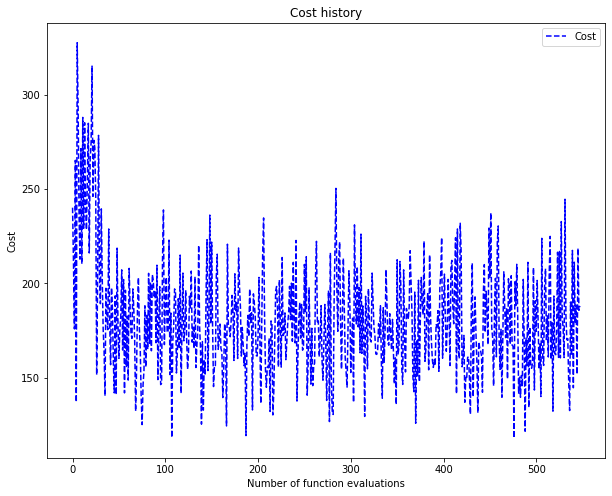

In [25]:
# print the cost history
opt_results.plot_cost()

In [26]:
# prints a large output (commented by default)
# pprint(opt_results.intermediate)

In [28]:
print(opt_results.optimized)

{'optimized angles': [2.890686552689141, 0.5951542162532422, 0.17300700722767853, 0.8391814462043803], 'optimized cost': 118.03999999999998, 'optimized measurement outcomes': Counter({'01100001': 4, '10011110': 4, '01011110': 3, '11011100': 3, '01010110': 3, '00110001': 3, '01111100': 3, '10010110': 3, '00011110': 3, '10100001': 3, '10101010': 2, '11010100': 2, '11011010': 2, '00111111': 2, '11001110': 2, '01001000': 2, '11010011': 1, '00111011': 1, '10100010': 1, '11100001': 1, '00011001': 1, '11011110': 1, '00111101': 1, '10000111': 1, '10001001': 1, '01000000': 1, '11100111': 1, '10000011': 1, '10010100': 1, '01110101': 1, '10110010': 1, '10000001': 1, '10011100': 1, '10101001': 1, '01101011': 1, '01100101': 1, '11011001': 1, '01000100': 1, '11101010': 1, '01001010': 1, '01001111': 1, '01010101': 1, '11000100': 1, '10000000': 1, '11000000': 1, '10010001': 1, '01011100': 1, '00100011': 1, '00101001': 1, '00111001': 1, '00000111': 1, '01100010': 1, '01011010': 1, '10000010': 1, '00010

In [30]:
opt_results.most_probable_states

{'solutions_bitstrings': ['01100001', '10011110'], 'bitstring_energy': 25.0}